## Import Libraries

In [1]:
import json
import re
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import networkx as nx
import inflect

## Define Classes

In [2]:
# Class to export the subject, object and relations to a JSON file

class exportJson:

    def __init__(self):
        super(exportJson, self).__init__()

    def dump_data(self, data):
        my_data = data.to_json('knowledge', orient='index')

In [3]:
class Graph:

    def __init__(self):
        super(Graph, self).__init__()
        self.x = GetEntity()

    def construct_graph(self, data):
        entity_list = data.values.tolist()
        source, relations, target = [],[],[]

        for i in entity_list:
            source.append(i[0])
            relations.append(i[1])
            target.append(i[3])


        kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
        G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(G, k = 0.5)
        ff = nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

        plt.show()

In [4]:
class QuestionAnswer:

    def __init__(self):
        super(QuestionAnswer, self).__init__()
        self.complex = ComplexFunc()
        self.nlp = spacy.load('en_core_web_sm')
        self.p = inflect.engine()

    def find_answer(self, question, c):
        p = self.complex.question_pairs(question)

        if p == [] or p is None:
            return "Not Applicable"

        pair = p[0]

        f = open("knowledge","r", encoding="utf8")
        listData = f.readlines()

        relQ = []
        loaded = json.loads(listData[0])
        relationQ = self.nlp(pair[1])


        for i in relationQ:
            relationQ = i.lemma_
            relQ.append(relationQ)

        objectQ = pair[3]
        subList = []
        timeQ = str(pair[4]).lower()
        placeQ = str(pair[5]).lower()

        relationQ = " ".join(relQ)

        if pair[0] in ('who'):

            for i in loaded:
                relationS = [relation for relation in self.nlp(loaded[str(i)]["relation"])]
                relationSSS = " ".join([relation.lemma_ for relation in self.nlp(loaded[str(i)]["relation"])])

                relationS = [i.lemma_ for i in relationS]
                relationS = relationS[0]

                if relationS == relationQ:
                    objectS = loaded[str(i)]["target"]
                    objectS = re.sub('-', ' ', objectS)
                    objectQ = re.sub('-', ' ', objectQ)

                    if self.p.singular_noun(objectS):
                        objectS = self.p.singular_noun(objectS)
                    if self.p.singular_noun(objectQ):
                        objectQ = self.p.singular_noun(objectQ)

                    if objectS == objectQ:
                        if str(pair[4]) != "":
                            timeS = [str(loaded[str(i)]["time"]).lower()]
                            # print(timeQ, timeS)
                            if timeQ in timeS:
                                answer_subj = loaded[str(i)]["source"]
                                subList.append(answer_subj)
                        else:
                            answer_subj = loaded[str(i)]["source"]
                            subList.append(answer_subj)
                elif str(relationSSS) == str(relationQ):
                    objectS = loaded[str(i)]["target"]
                    objectS = re.sub('-', ' ', objectS)

                    if objectS == objectQ:
                        if str(pair[4]) != "":
                            timeS = [str(loaded[str(i)]["time"]).lower()]
                            if timeQ in timeS:
                                answer_subj = loaded[str(i)]["source"]
                                subList.append(answer_subj)
                        else:
                            answer_subj = loaded[str(i)]["source"]
                            subList.append(answer_subj)


            answer_subj = ",".join(subList)
            if answer_subj == "":
                return "None"
            return answer_subj

        elif pair[3] in ['what']:
            subjectQ = pair[0]
            subList = []
            for i in loaded:
                subjectS = loaded[str(i)]["source"]
                if subjectQ == subjectS:
                    relationS = [relation for relation in self.nlp(loaded[str(i)]["relation"])]
                    relationS = [i.lemma_ for i in relationS]
                    if len(relationS) > 1:
                        relationS = " ".join(relationS)
                    else:
                        relationS = relationS[0]
                    if relationQ == relationS:
                        if str(pair[5]) != "":
                            placeS = [str(place).lower() for place in self.nlp(loaded[str(i)]["place"])]
                            if placeQ in placeS:
                                if str(pair[4]) != "":
                                    timeS = [str(time).lower() for time in self.nlp(loaded[str(i)]["time"])]
                                    if timeQ in timeS:
                                        answer_subj = loaded[str(i)]["target"]
                                        subList.append(answer_subj)
                                else:
                                    answer_subj = loaded[str(i)]["target"]
                                    subList.append(answer_subj)
                        else:
                            if str(pair[4]) != "":
                                timeS = [str(time).lower() for time in self.nlp(loaded[str(i)]["time"])]
                                if timeQ in timeS:
                                    answer_subj = loaded[str(i)]["target"]
                                    subList.append(answer_subj)
                            else:
                                answer_subj = loaded[str(i)]["target"]
                                subList.append(answer_subj)

            answer_obj = ",".join(subList)
            if answer_obj == "":
                return "None"
            return answer_obj

        elif pair[4] in ['when']:
            subjectQ = pair[0]
            for i in loaded:
                subjectS = loaded[str(i)]["source"]
                if subjectQ == subjectS:
                    relationS = [relation for relation in self.nlp(loaded[str(i)]["relation"])]
                    relationS = [i.lemma_ for i in relationS]
                    relBuffer = relationS

                    if len(relBuffer) < 2:
                        relationS = relBuffer[0]
                    else:
                        if str(relBuffer[1]).lower() == 'to':
                            relationS = " ".join(relationS)
                        else:
                            relationS = relationS[0]
                            extraIN = relBuffer[1].lower()

                    if relationQ == relationS:
                        if str(pair[5]) != "":
                            placeS = [str(place).lower() for place in self.nlp(loaded[str(i)]["place"])]
                            if placeQ in placeS:
                                if loaded[str(i)]["time"] != '':
                                    answer_obj = loaded[str(i)]["time"]
                                    return answer_obj
                                return None
                        else:
                            if loaded[str(i)]["time"] != '':
                                answer_obj = loaded[str(i)]["time"]
                                return answer_obj
                            return None

        elif pair[5] in ['where']:
            subjectQ = pair[0]
            for i in loaded:
                subjectS = loaded[str(i)]["source"]
                if subjectQ == subjectS:
                    relationS = [relation for relation in self.nlp(loaded[str(i)]["relation"])]
                    relationS = [i.lemma_ for i in relationS]
                    relationS = relationS[0]

                    if relationQ == relationS:
                        if str(pair[4]) != "":
                            timeS = [str(time).lower() for time in self.nlp(loaded[str(i)]["time"])]
                            if timeQ in timeS:
                                answer_obj = loaded[str(i)]["place"]
                                if answer_obj in (" ",""):
                                    if int(i)<int(len(loaded)-1):
                                        pass
                                    return None
                                return answer_obj
                            return None
                        
                        answer_obj = loaded[str(i)]["place"]
                        if answer_obj in (" ",""):
                            if int(i)<int(len(loaded)-1):
                                pass
                            return None
                        return answer_obj

In [5]:

class ComplexFunc:

    def __init__(self):
        self.ent_pairs = list()
        self.nlp = spacy.load('en_core_web_sm')

    def get_time_place_from_sent(self,sentence):
        xdate =[]
        xplace =[]
        for i in sentence.ents:
            if i.label_ in ('DATE'):
                xdate.append(str(i))

            if i.label_ in ('GPE'):
                xplace.append(str(i))

        return xdate, xplace

    def find_obj(self, sentence, place, time):
        object_list = []
        # buffer_obj = ''

        for word in sentence:
            if word.dep_ in ('obj', 'dobj', 'pobj'):
                buffer_obj = word

                if str(word) in place and word.nbor(-1).dep_ in ('prep') and str(word.nbor(-1)) == "of":
                    pass
                else:
                    if str(word) not in time and str(word) not in place:
                        for child in word.subtree:
                            if child.dep_ in ('conj', 'dobj', 'pobj', 'obj') and (str(child) not in time) and (str(child) not in place):
                                if [i for i in child.lefts]:
                                    if child.nbor(-1).dep_ in ('nummod') and child.dep_ in ('dobj', 'obj','pobj'):
                                        child = str(child.nbor(-1)) + " " + str(child)
                                        object_list.append(str(child))

                                    elif child.nbor(-1).dep_ in ('punct'):
                                        if child.nbor(-2).dep_ in ('compound'):
                                            child = str(child.nbor(-2)) + str(child.nbor(-1)) + str(child)
                                            object_list.append(str(child))
                                        elif child.nbor(-2).dep_ in ('amod'):
                                            child = str(child.nbor(-2)) + str(child.nbor(-1)) + str(child)
                                            object_list.append(str(child))

                                    elif child.nbor(-1).dep_ in ('compound'):
                                        child_with_comp = ""
                                        for i in child.subtree:
                                            if i.dep_ in ('compound', 'nummod','quantmod'):
                                                if child_with_comp == "":
                                                    child_with_comp = str(i)
                                                else:
                                                    child_with_comp = child_with_comp +" "+ str(i)
                                            elif i.dep_ in ('cc'):
                                                break
                                        child = child_with_comp + " " + str(child)
                                        object_list.append(str(child))

                                    elif child.nbor(-1).dep_ in ('det'):
                                        object_list.append(str(child))

                                elif [i for i in child.rights]:
                                    if str(child.text) not in object_list:
                                        object_list.append(str(child.text))

                                    for a in child.children:
                                        if a.dep_ in ('conj'):
                                            if a.nbor(-1).dep_ in ('punct'):
                                                pass
                                            else:
                                                object_list.extend( [ str(a.text) ] )

                                else:
                                    if str(child) not in object_list:
                                        object_list.append(str(child))

                    elif str(word) in place and str(word.nbor(-1)) != "of":
                        if object_list == []:
                            object_list.append(str(word))
                        else:
                            pass
                    else:
                        if str(word) in time and object_list == []:
                            object_list.append(str(word))

        # print("Buffer object", buffer_obj)
        return object_list, buffer_obj

    def find_subj(self, sentence):
        subject_list = []
        dep_word = [word.dep_ for word in sentence]
        word_dep_count_subj = [dep_word.index(word) for word in dep_word if word in ('nsubj', 'subj', 'nsubjpass')]
        if word_dep_count_subj:
            word_dep_count_subj = word_dep_count_subj[0] + 1
        else:
            word_dep_count_subj = 1

        subject_final = ""
        for word in sentence:
            if word_dep_count_subj > 0:
                if word.dep_ in ('compound') or word.dep_ in ('nmod') or word.dep_ in ('amod') or word.dep_ in ('poss') or word.dep_ in ('case') or word.dep_ in ('nummod'):
                    if subject_final == "":
                        subject_final = str(word)
                        word_dep_count_subj = word_dep_count_subj - 1
                    elif word.dep_ in ('case'):
                        subject_final = subject_final+ "" +str(word)
                        word_dep_count_subj = word_dep_count_subj - 1
                    else:
                        subject_final = subject_final+ " " +str(word)
                        word_dep_count_subj = word_dep_count_subj - 1
                elif word.dep_ in ('nsubj', 'subj', 'nsubjpass'):
                    if subject_final == "":
                        subject_final = str(word)
                        subject_list.extend([str(a.text) for a in word.subtree if a.dep_ in ('conj')])
                        word_dep_count_subj = word_dep_count_subj - 1
                        break
                    else:
                        subject_final = subject_final+" "+str(word)
                        subject_list.extend([str(a.text) for a in word.subtree if a.dep_ in ('conj')])
                        word_dep_count_subj = word_dep_count_subj - 1
                        break
                else:
                    pass

        subject_list.append(subject_final)
        return subject_list

    def find_relation(self, buffer_obj):
        aux_relation = ""
        relation = [w for w in buffer_obj.ancestors if w.dep_ =='ROOT']

        if relation:
            relation = relation[0]
            sp_relation = relation
            if relation.nbor(1).pos_ in ('VERB'):
                if relation.nbor(2).dep_ in ('xcomp'):
                    relation = ' '.join((str(relation), str(relation.nbor(1)), str(relation.nbor(2))))
                else:
                    relation = str(relation)
                    if str(sp_relation.nbor(2)) != 'and':
                        if sp_relation.nbor(1).dep_ in ('xcomp'):
                            aux_relation = str(sp_relation.nbor(1))
                        else:
                            aux_relation = str(sp_relation.nbor(2))
            elif relation.nbor(1).pos_ in ('ADP', 'PART') and relation.nbor(1).dep_ in ('aux') and str(relation.nbor(1)) == 'to':
                relation = " ".join((str(relation), str(relation.nbor(1))))
                if str(sp_relation.nbor(2)) != 'and':
                    aux_relation = str(sp_relation.nbor(2))
            elif relation.nbor(1).dep_ in ('prep') and str(relation.nbor(1)) == 'to' and (relation.nbor(1)).dep_ not in ('obj','dobj','pobj','det'):
                relation = " ".join((str(relation), str(relation.nbor(1))))
            else:
                relation = str(relation)
        else:
            relation = 'unknown'

        return relation, aux_relation

    def normal_sent(self, sentence):
        time, place = self.get_time_place_from_sent(sentence)

        subject_list, object_list = [], []

        aux_relation, child_with_comp = "", ""

        subject_list = self.find_subj(sentence)
        object_list, buffer_obj = self.find_obj(sentence, place, time)
        relation, aux_relation = self.find_relation(buffer_obj)

        self.ent_pairs = []

        if time:
            time = time[0]
        else:
            time = ""

        if place:
            place = place[0]
        else:
            place = ""

        pa, pb=[], []
        for m in subject_list:
            pa.append([m])

        for n in object_list:
            pb.append([n])


        for m in range(0, len(pa)):
            for n in range(0, len(pb)):
                self.ent_pairs.append([str(pa[m][0]).lower(), str(relation).lower(),str(aux_relation).lower(), str(pb[n][0]).lower(), str(time), str(place)])

        return self.ent_pairs

    def question_pairs(self, question__):

        questionNLPed = self.nlp(question__)
        maybe_object = ([i for i in questionNLPed if i.dep_ in ('obj', 'pobj', 'dobj')])
        maybe_place, maybe_time = [], []
        aux_relation = ""
        maybe_time, maybe_place = self.get_time_place_from_sent(questionNLPed)
        object_list = []

        for obj in questionNLPed:
            objectNEW = obj

            if obj.dep_ in ('obj', 'dobj', 'pobj', 'xcomp') and str(obj).lower() != "what":
                buffer_obj = obj

                if obj.dep_ in ('xcomp') and obj.nbor(-1).dep_ in ('aux') and obj.nbor(-2).dep_ in ('ROOT'):
                    continue

                if str(obj) in maybe_place and obj.nbor(-1).dep_ in ('prep') and str(obj.nbor(-1)) == "of":
                    pass
                else:
                    if str(obj) not in maybe_time and str(obj) not in maybe_place:
                        for child in obj.subtree:
                            if child.dep_ in ('conj', 'dobj', 'pobj', 'obj'):
                                if [i for i in child.lefts]:
                                    if child.nbor(-1).dep_ in ('punct') and child.nbor(-2).dep_ in ('compound'):
                                        child = str(child.nbor(-2)) + str(child.nbor(-1)) + str(child)
                                        object_list.append(str(child))

                                    elif child.nbor(-1).dep_ in ('compound'):
                                        child_with_comp = ""
                                        for i in child.subtree:
                                            if i.dep_ in ('compound', 'nummod','quantmod'):
                                                if child_with_comp == "":
                                                    child_with_comp = str(i)
                                                else:
                                                    child_with_comp = child_with_comp +" "+ str(i)
                                            elif i.dep_ in ('cc'):
                                                break
                                        child = child_with_comp + " " + str(child)

                                        object_list.append(str(child))

                                    elif child.nbor(-1).dep_ in ('det'):
                                        object_list.append(str(child))

                                elif [i for i in child.rights]:
                                    if str(child.text) not in object_list:
                                        object_list.append(str(child.text))

                                    for a in child.children:
                                        if a.dep_ in ('conj'):
                                            if a.nbor(-1).dep_ in ('punct'):
                                                pass
                                            else:
                                                object_list.extend( [ str(a.text) ] )

                                else:
                                    if str(child) not in object_list:
                                        object_list.append(str(child))

                            elif obj.dep_ in ('xcomp'):
                                object_list.append(str(obj))

                    elif str(obj) in maybe_place and str(obj.nbor(-1)) != "of":
                        object_list.append(str(obj))
                    else:
                        if str(obj) in time and object_list == []:
                            object_list.append(str(obj))


                obj = object_list[-1]

                relation = [w for w in objectNEW.ancestors if w.dep_ =='ROOT']
                if relation:
                    relation = relation[0]
                    sp_relation = relation
                    if relation.nbor(1).pos_ in ('ADP', 'PART', 'VERB'):
                        if relation.nbor(2).dep_ in ('xcomp'):
                            aux_relation = str(relation.nbor(2))
                            relation = str(relation)+" "+str(relation.nbor(1))
                        else:
                            relation = str(relation)

                    subject = [a for a in sp_relation.lefts if a.dep_ in ('subj', 'nsubj','nsubjpass')]
                    if subject:
                        subject = subject[0]
                    else:
                        subject = 'unknown'
                else:
                    relation = 'unknown'

                self.ent_pairs = []

                if maybe_time and maybe_place:
                    self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(obj).lower(), str(maybe_time[0]).lower(), str(maybe_place[0]).lower()])
                elif maybe_time:
                    self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(obj).lower(), str(maybe_time[0]).lower(), str("").lower()])
                elif maybe_place:
                    self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(obj).lower(), str("").lower(), str(maybe_place[0]).lower()])
                else:
                    self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(obj).lower(), str("").lower(), str("").lower()])
                return self.ent_pairs

            elif str(obj).lower() == "what":
                relation = [w for w in objectNEW.ancestors if w.dep_ =='ROOT']
                if relation:
                    relation = relation[0]
                    sp_relation = relation
                    if relation.nbor(1).pos_ in ('ADP', 'PART', 'VERB'):
                        if relation.nbor(2).dep_ in ('xcomp'):
                            aux_relation = str(relation.nbor(2))
                            relation = str(relation)+" "+str(relation.nbor(1))
                        else:
                            relation = str(relation)

                    subject = self.find_subj(questionNLPed)
                    subject = subject[-1]

                else:
                    relation = 'unknown'

                self.ent_pairs = []
                if maybe_time and maybe_place:
                    self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(obj).lower(), str(maybe_time[0]).lower(), str(maybe_place[0]).lower()])
                elif maybe_time:
                    self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(obj).lower(), str(maybe_time[0]).lower(), str("").lower()])
                elif maybe_place:
                    self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(obj).lower(), str("").lower(), str(maybe_place[0]).lower()])
                else:
                    self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(obj).lower(), str("").lower(), str("").lower()])
                return self.ent_pairs

            elif obj.dep_ in ('advmod'):
                if str(obj).lower() == 'where':
                    relation = [w for w in obj.ancestors if w.dep_ =='ROOT']
                    if relation:
                        relation = relation[0]
                        sp_relation = relation
                        if relation.nbor(1).pos_ in ('ADP', 'PART', 'VERB'):
                            if relation.nbor(2).dep_ in ('xcomp'):
                                aux_relation = str(relation.nbor(2))
                                relation = str(relation)+" "+str(relation.nbor(1))
                            else:
                                relation = str(relation)


                        subject = self.find_subj(questionNLPed)
                        subject = subject[-1]

                    else:
                        relation = 'unknown'

                    self.ent_pairs = []
                    if maybe_object:
                        if maybe_time and maybe_place:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(maybe_object[-1]).lower(), str(maybe_time[0]).lower(), str("where").lower()])
                        elif maybe_time:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(maybe_object[-1]).lower(), str(maybe_time[0]).lower(), str("where").lower()])
                        elif maybe_place:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(maybe_object[-1]).lower(), str("").lower(), str("where").lower()])
                        else:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(maybe_object[-1]).lower(), str("").lower(), str("where").lower()])
                    else:
                        if maybe_time and maybe_place:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str("").lower(), str(maybe_time[0]).lower(), str("where").lower()])
                        elif maybe_time:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str("").lower(), str(maybe_time[0]).lower(), str("where").lower()])
                        elif maybe_place:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str("").lower(), str("").lower(), str("where").lower()])
                        else:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str("").lower(), str("").lower(), str("where").lower()])


                    return self.ent_pairs

                elif str(obj).lower() == 'when':
                    relation = [w for w in obj.ancestors if w.dep_ =='ROOT']
                    if relation:
                        relation = relation[0]
                        sp_relation = relation
                        if relation.nbor(1).pos_ in ('ADP', 'PART', 'VERB'):
                            if relation.nbor(2).dep_ in ('xcomp'):
                                relation = ' '.join((str(relation), str(relation.nbor(1)), str(relation.nbor(2))))
                            else:
                                relation = ' '.join((str(relation), str(relation.nbor(1))))

                        for left_word in sp_relation.lefts:
                            if left_word.dep_ in ('subj', 'nsubj','nsubjpass'):
                                if [i for i in left_word.lefts]:
                                    for left_of_left_word in left_word.lefts:
                                        subject = str(left_of_left_word) + " " + str(left_word)
                                else:
                                    subject = str(left_word)
                    else:
                        relation = 'unknown'

                    self.ent_pairs = []
                    if maybe_object:
                        if maybe_time and maybe_place:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(maybe_object[-1]).lower(), str("when").lower(), str(maybe_place[0]).lower()])
                        elif maybe_time:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(maybe_object[-1]).lower(), str("when").lower(), str("").lower()])
                        elif maybe_place:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(maybe_object[-1]).lower(), str("when").lower(), str(maybe_place[0]).lower()])
                        else:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str(maybe_object[-1]).lower(), str("when").lower(), str("").lower()])
                    else:
                        if maybe_time and maybe_place:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str("").lower(), str("when").lower(), str(maybe_place[0]).lower()])
                        elif maybe_time:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str("").lower(), str("when").lower(), str("").lower()])
                        elif maybe_place:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str("").lower(), str("when").lower(), str(maybe_place[0]).lower()])
                        else:
                            self.ent_pairs.append([str(subject).lower(), str(relation).lower(),str(aux_relation).lower(), str("").lower(), str("when").lower(), str("").lower()])

                    return self.ent_pairs


In [6]:
class change_nouns:

    def __init__(self):
        super(change_nouns, self).__init__()
        self.nlp = spacy.load('en_core_web_sm')

    def resolved(self, text):
        flag = True

        official_subject = "Unknown"

        sentences = []
        prev_subjs = []

        temp_text = text
        pos_of_brackets = {pos:char for pos, char in enumerate(temp_text) if str(char) in ("(",")")}


        text = self.nlp(text)



        for sent in text.sents:
            prev_subj, compound_is, last_word = "", "", ""

            dep_word = [word.dep_ for word in sent]
            word_dep_count_subj = [dep_word.index(word) for word in dep_word if word in ('nsubj', 'subj', 'nsubjpass')]


            try:
                word_dep_count_subj = word_dep_count_subj[-1] + 1
            except IndexError:
                word_dep_count_subj = 1

            more_subjs = [word for word in dep_word if word in ('nsubj', 'subj', 'nsubjpass')]

            for word in sent:
                if len(more_subjs) > 1:
                    if word.dep_ in more_subjs:
                        if word.dep_ in ['nsubjpass']:
                            break
                        elif word.dep_ in ('nsubj','subj'):
                            if word_dep_count_subj > 0:
                                if word.dep_ in ('compound') or word.dep_ in ('nmod', 'amod'):
                                    if compound_is == "":
                                        compound_is = str(word)
                                        word_dep_count_subj = word_dep_count_subj - 1
                                    else:
                                        compound_is = compound_is+ " " +str(word)
                                        word_dep_count_subj = word_dep_count_subj - 1

                                elif word.dep_ in ('nsubj', 'subj', 'nsubjpass'):
                                    pronoun = [i for i in word.subtree]

                                    if compound_is == "":
                                        if str(word) not in ('he','HE', 'He','she','SHE', 'She','it','IT', 'It'):
                                            prev_subj = str(word)
                                            if str(pronoun[0]) not in ('his','His', 'her','Her', 'its', 'Its'):
                                                prev_subjs = [prev_subj]
                                                official_subject = prev_subjs[0]
                                                word_dep_count_subj = word_dep_count_subj - 1

                                    else:
                                        if str('poss') in [str(i.dep_) for i in word.subtree]:
                                            prev_subj = compound_is
                                            word_dep_count_subj = word_dep_count_subj - 1
                                            prev_subjs = [prev_subj]
                                        else:
                                            prev_subj = compound_is+" "+str(word)
                                            word_dep_count_subj = word_dep_count_subj - 1
                                            prev_subjs = [prev_subj]
                                            official_subject = prev_subjs[0]

                                    if str(word) in ('he','HE', 'He','she','SHE', 'She','it','IT', 'It'):
                                        new_word = prev_subjs[-1]
                                        sentences.append(str(sent).replace(str(word), str(new_word)))
                                        flag = False

                                    if pronoun:
                                        if len(pronoun) <= 2 and str(pronoun[0]) in ('his','His', 'her','Her', 'its', 'Its'):
                                            print(official_subject)
                                            new_word = str(official_subject)+"\'s"
                                            # print(new_word)
                                            sentences.append(str(sent).replace((str(pronoun[0])), str(new_word)))
                                            flag = False
                                        elif len(pronoun)>2 and str(pronoun[0]) in ('his','His', 'her','Her', 'its', 'Its'):
                                            new_word = str(official_subject)+"\'s"
                                            sentences.append(str(sent).replace(str(pronoun[0]), str(new_word)))
                                            flag = False


                                elif word.dep_ in ('nsubj','subj','nsubjpass') and str(word) not in ('he','HE', 'He','she','SHE', 'She','it','IT', 'It'):
                                    last_word = word
                                else:
                                    pass
                else:
                    if word_dep_count_subj > 0:
                        if word.dep_ in ('compound') or word.dep_ in ('nmod', 'amod'):
                            if compound_is == "":
                                compound_is = str(word)
                                word_dep_count_subj = word_dep_count_subj - 1
                            else:
                                compound_is = compound_is+ " " +str(word)
                                word_dep_count_subj = word_dep_count_subj - 1

                        elif word.dep_ in ('nsubj', 'subj', 'nsubjpass'):
                            pronoun = [i for i in word.subtree]

                            if compound_is == "":
                                if str(word) not in ('he','HE', 'He','she','SHE', 'She','it','IT', 'It'):
                                    prev_subj = str(word)
                                    if str(pronoun[0]) not in ('his','His', 'her','Her', 'its', 'Its'):
                                        prev_subjs = [prev_subj]
                                        official_subject = prev_subjs[0]
                                        word_dep_count_subj = word_dep_count_subj - 1

                            else:
                                if str('poss') in [str(i.dep_) for i in word.subtree]:
                                    prev_subj = compound_is
                                    word_dep_count_subj = word_dep_count_subj - 1
                                    prev_subjs = [prev_subj]
                                else:
                                    prev_subj = compound_is+" "+str(word)
                                    word_dep_count_subj = word_dep_count_subj - 1
                                    prev_subjs = [prev_subj]
                                    official_subject = prev_subjs[0]

                            if str(word) in ('he','HE', 'He','she','SHE', 'She','it','IT', 'It'):
                                new_word = prev_subjs[-1]
                                sentences.append(str(sent).replace(str(word), str(new_word)))
                                flag = False

                            if pronoun:
                                if len(pronoun) <= 2 and str(pronoun[0]) in ('his','His', 'her','Her', 'its', 'Its'):
                                    new_word = str(official_subject)+"\'s"
                                    sentences.append(str(sent).replace((str(pronoun[0])), str(new_word)))
                                    flag = False
                                elif len(pronoun)>2 and str(pronoun[0]) in ('his','His', 'her','Her', 'its', 'Its'):
                                    new_word = str(official_subject)+"\'s"
                                    sentences.append(str(sent).replace(str(pronoun[0]), str(new_word)))
                                    flag = False


                        elif word.dep_ in ('nsubj','subj','nsubjpass') and str(word) not in ('he','HE', 'He','she','SHE', 'She','it','IT', 'It'):
                            last_word = word
                        else:
                            pass

            if flag:
                sentences.append(str(sent))
            else:
                flag = True

        resolved_text = " ".join(sentences)
        return resolved_text

    def check_for_multi_and_(self, sentence):
        x = []
        count = 0
        for word in sentence:
            count += 1
            if word.dep_ in ('cc'):
                x.append(count-1)

        depen = []
        for i in x:
            depen.append([word.dep_ for word in sentence[:i]])

        senten1, senten2 = "", ""
        list2 = ["nsubj", "ROOT", "dobj"]

        for list1 in depen:
            check = all(item in list1 for item in list2)

            if check:
                return True, depen, x

        return False, [], 0

    def diff_sent_return(self, sentence, depen, pos_of_and):
        newcount = -1
        senten1, senten2 = "", ""
        list2 = ["nsubj", "ROOT", "dobj"]

        for i in depen:
            newcount += 1
            list1 = i
            check = all(item in list1 for item in list2)
            if check:
                lista = [str(w) for w in sentence]

                p1 = lista[:pos_of_and[newcount]]
                p2 = lista[pos_of_and[newcount]+1:]


                senten1 = " ".join(p1)
                senten2 = " ".join(p2)

                senten1 = self.nlp(senten1)
                senten2 = self.nlp(senten2)

        return str(senten1), str(senten2)

In [7]:
class GetEntity:

    def __init__(self):
        super(GetEntity, self).__init__()
        self.complex = ComplexFunc()
        self.nlp = spacy.load('en_core_web_sm')
        self.change = change_nouns()

    def preprocess_text(self, input_file):
        text_strip = [text.strip() for text in input_file]
        preprocessed_text = [text for text in text_strip if text not in ('', ' ')]
        text = " ".join(preprocessed_text)
        text = self.change.resolved(text)
        text = self.nlp(text)
        return text

    def get_entity(self, text):
        ent_pairs, final_entity_pairs = [],[]
        sentences = [one_sentence.text.strip() for one_sentence in text.sents]

        for one_sentence in sentences:
            final_entity_pairs = []
            one_sentence = self.nlp(one_sentence)

            dep = [token.dep_ for token in one_sentence]

            normal_sent_ = self.complex.normal_sent(one_sentence)

            if normal_sent_:
                for pair in normal_sent_:
                    ent_pairs.append(pair)

                pairs = pd.DataFrame(ent_pairs, columns=['source', 'relation', 'aux_relation', 'target', 'time', 'place'])
                number_of_ent_pairs = str(len(ent_pairs))

                final_entity_pairs.append(pairs)

        if final_entity_pairs:
            return final_entity_pairs, number_of_ent_pairs    
        return None, None

## Create Class Objects

In [8]:
qna = QuestionAnswer()
getEntity = GetEntity()
export = exportJson()
graph = Graph()

## Load Input Data

In [9]:
inputfile = "data.txt"
input_file = open(inputfile,"r+")

## Preprocess the Data

In [10]:
refined_text = getEntity.preprocess_text(input_file)

## Extract Relations from Refined Data

In [11]:
dataEntities, numberOfPairs = getEntity.get_entity(refined_text)
export.dump_data(dataEntities[0])

## Print the Relations

In [12]:
print(dataEntities[0])

   source relation aux_relation      target time place
0    ravi      ate               chocolates           
1    ravi      was                   school           
2   priya  went to                  station           
3   buses  stopped                  station           
4  vikram  playing                   school           
5  vikram  travels                    buses           
6  vikram     sits                    priya           
7    ravi    plays                   vikram           


## Plot the Knowledge Graph

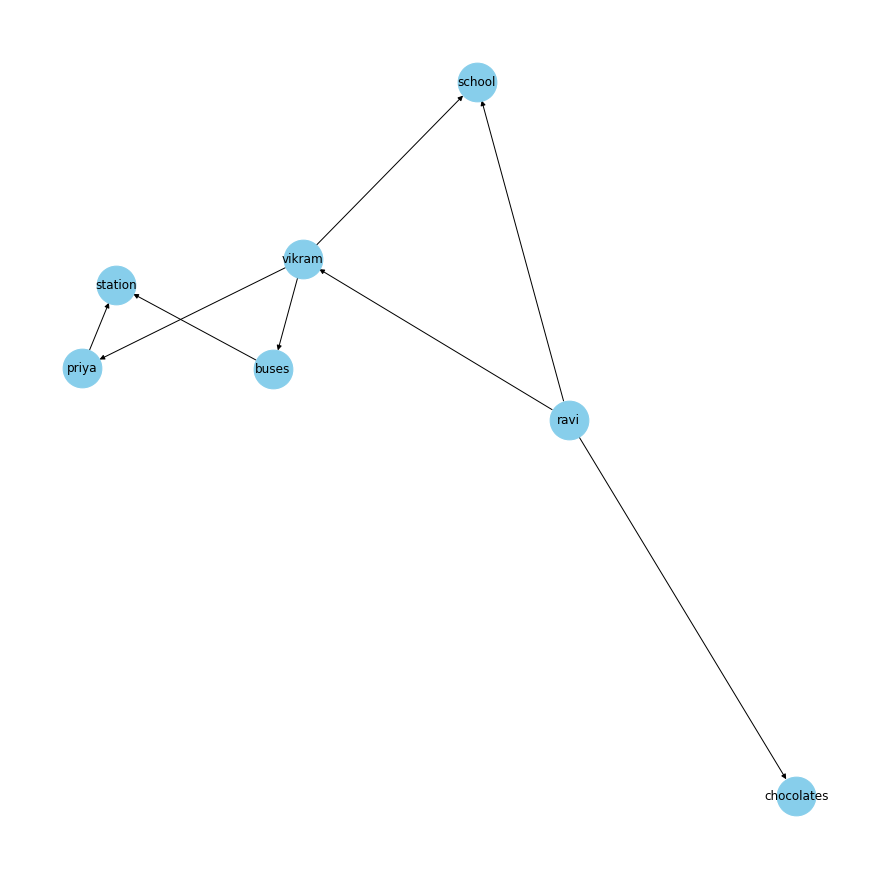

In [13]:
graph.construct_graph(dataEntities[0])

## Question Answering

In [14]:
def get_answer(question, pairs):
    answer = qna.find_answer(question, pairs)
    print("Question: ",question)
    print("Answer:   ",answer)
    print("\n")

In [15]:
get_answer("What did Ravi eat?", numberOfPairs)
get_answer("Who was late to school?", numberOfPairs)
get_answer("Who went to the station?", numberOfPairs)
get_answer("Vikram travels in what?", numberOfPairs)
get_answer("Who plays with Vikram?", numberOfPairs)
get_answer("Who sits next to Priya?", numberOfPairs)

Question:  What did Ravi eat?
Answer:    chocolates


Question:  Who was late to school?
Answer:    ravi


Question:  Who went to the station?
Answer:    priya


Question:  Vikram travels in what?
Answer:    buses


Question:  Who plays with Vikram?
Answer:    ravi


Question:  Who sits next to Priya?
Answer:    vikram


